In [464]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [465]:
# def preprocessing(url_data : str = '../data/weatherAUS.csv', city : str = 'Sydney'):

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = 'Sydney'

df = df[df['Location'].isin([city])]

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))
if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

df.dropna(inplace = True)
# print('apres', df.info())

df.to_csv('../data_saved/data_mat2.csv')


In [466]:
X = df.drop(columns = 'RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)
print(y_train.value_counts(normalize = True))
print(y_train.value_counts())


param_grid = {
    'n_estimators': [755],  # Nombre d'arbres
    'max_depth': [8],  # Profondeur des arbres
    'max_features': ['sqrt'],  # Nombre de caractéristiques à considérer
    'min_samples_split': [3],  # Nombre minimum d'échantillons requis pour diviser un noeud
    'min_samples_leaf': [15],  # Nombre minimum d'échantillons requis dans une feuille
    'criterion' : ['gini'],
    'bootstrap' : [True]
}

model = GridSearchCV(
    estimator=RandomForestClassifier(class_weight={0: 1/poids[0], 1: 1/poids[1]}, random_state=42),
    param_grid=param_grid,
    cv=5,  # Validation croisée avec 5 plis
    scoring='f1',  # Nous utilisons F1-score comme critère de scoring
    n_jobs=-1,  # Utiliser tous les cœurs disponibles pour l'entraînement
    verbose=1  # Afficher les progrès
)

# Ajuster le modèle avec GridSearch
model.fit(X_train_scaled, y_train)

print("Meilleurs paramètres trouvés :", model.best_params_)
print("Meilleure performance F1 : ", model.best_score_)

best_model = model.best_estimator_

y_pred = best_model.predict(X_test_scaled)

# Afficher les scores
print('score accuracy : ', best_model.score(X_test_scaled, y_test))
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print('brier score : ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')

RainTomorrow
0.0    0.751362
1.0    0.248638
Name: proportion, dtype: float64
RainTomorrow
0.0    1517
1.0     502
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres trouvés : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 3, 'n_estimators': 755}
Meilleure performance F1 :  0.6411197624114626
score accuracy :  0.8308605341246291
f1 score :  0.6918918918918919
roc-auc score :  0.8092690358927117
brier score :  0.16913946587537093 


[[432  75]
 [ 39 128]] 




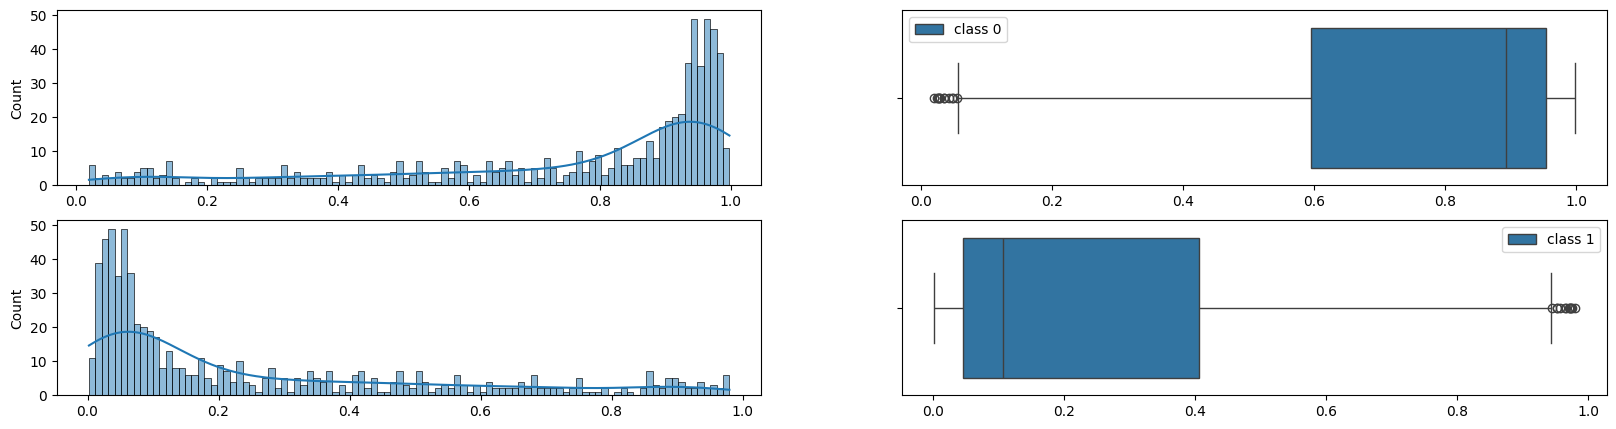

In [467]:
plt.figure(figsize = (20, 5))
plt.subplot(221)
sns.histplot(y_score_class0, bins = 100, label = 'class 0', kde = True)
plt.subplot(222)
sns.boxplot(y_score_class0, label = 'class 0', orient = 'h')

plt.legend()
plt.subplot(223)
sns.histplot(y_score_class1, bins = 100, label = 'class 1', kde = True)
plt.subplot(224)
sns.boxplot(y_score_class1, label = 'class 1', orient = 'h')

plt.legend()

In [468]:
pd.DataFrame(model.predict_proba(X_test_scaled)).describe()

,0,1
count,674.000000,674.000000
mean,0.627872,0.372128
std,0.263127,0.263127
min,0.024125,0.022813
25%,0.438592,0.145792
50%,0.701441,0.298559
75%,0.854208,0.561408
max,0.977187,0.975875


In [469]:
feature_importance = np.abs(coefficients)
sorted_indices = np.argsort(feature_importance)[::-1] # Trier les indices en fonction des poids, du plus grand au plus petit

# Afficher les features les plus importantes
print("Features triées par poids absolu :")
for idx in sorted_indices:
    print(f"{X.columns[idx]} : {coefficients[idx]}")

Features triées par poids absolu :
MinTemp : -1.0855176744655783
Temp9am : 0.978661991452351
Humidity3pm : 0.773488428029218
Sunshine : -0.743244552200443
Humidity9am : 0.4332949522701983
Cloud3pm : 0.4115801835868284
WindDir3pm_cos : -0.3896222175181507
MaxTemp : 0.342684729837665
cos_months : -0.32074360076568725
Pressure9am : -0.19647352196749435
WindDir3pm_sin : -0.1961107366699225
WindSpeed3pm : 0.18883737513536775
RainToday : 0.17129718319057433
Pressure3pm : -0.12135318052206508
WindSpeed9am : 0.11370258122617212
year : 0.11129112343368132
Cloud9am : -0.09612934419896435
Evaporation : 0.09221731592264817
Rainfall : 0.09109933428090708
WindDir9am_sin : 0.05606503268689883
Temp3pm : 0.05361671297344634
WindDir9am_cos : -0.0018378515736915224
sin_months : -0.00035572622406475986


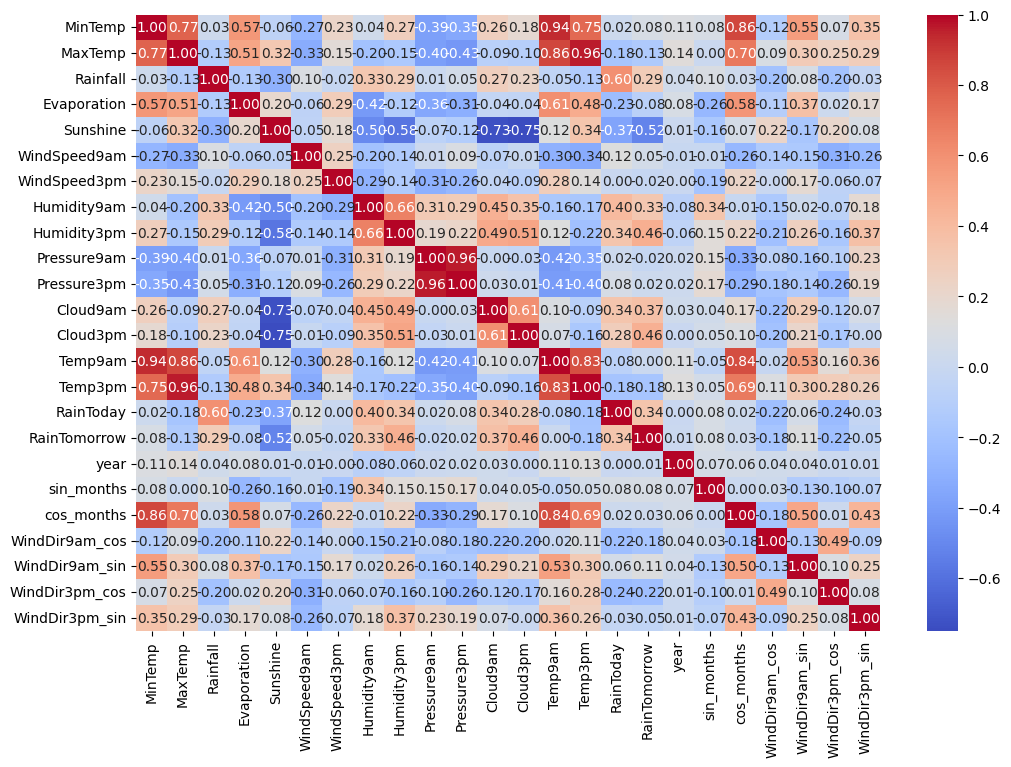

In [470]:
corr_matrix = df.corr()

# Visualiser la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()